# **Proyek: Prediksi Segmentasi Nasabah Menggunakan Model Klasifikasi**

### _Membangun Model Prediktif Berdasarkan Hasil Clustering_

- **Penyusun:** `Rozhak`
- **Versi Proyek:** `4.0`
- **Pembaruan Terakhir:** `9 September 2025`

## **1. Konteks Bisnis dan Tujuan Proyek**

Proyek ini adalah tahap kedua dari analisis nasabah, di mana kita membangun model *supervised learning* (klasifikasi). Tujuannya adalah untuk melatih sebuah model yang mampu memprediksi cluster (segmen) nasabah secara otomatis berdasarkan fitur-fitur mereka. Model ini akan menggunakan **label cluster yang dihasilkan dari skrip clustering sebelumnya** sebagai variabel target. Dengan demikian, bank dapat secara real-time mengklasifikasikan nasabah baru ke dalam segmen yang sudah ada untuk penanganan yang dipersonalisasi.

## **2. Pengaturan Lingkungan & Pustaka**

### **2.1. Impor Pustaka (Library)**

Pada tahap ini, kita akan mengimpor seluruh pustaka Python yang dibutuhkan untuk analisis data, prapemrosesan, pembangunan model machine learning, dan evaluasi.

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

sns.set_style('whitegrid')
print("[INFO] Pustaka berhasil diimpor.")

[INFO] Pustaka berhasil diimpor.


## **3. Pemuatan dan Eksplorasi Data Hasil Clustering**

### **3.1. Memuat Dataset**

Tahap krusial: kita tidak lagi menggunakan data mentah, melainkan memuat `data_clustering_inverse.csv` yang merupakan output dari skrip clustering. File ini sudah berisi data nasabah yang bersih beserta label cluster (`Target`) yang akan kita prediksi.

In [30]:
df = pd.read_csv('/content/data_clustering_inverse.csv')
print("[INFO] Dataset berhasil dimuat.")

[INFO] Dataset berhasil dimuat.


In [31]:
print("[ANALISIS] 5 Baris Pertama Dataset Hasil Clustering:")
display(df.head())

[ANALISIS] 5 Baris Pertama Dataset Hasil Clustering:


,TransactionAmount,TransactionType,Location,Channel,CustomerOccupation,TransactionDuration,LoginAttempts,AgeBin,AccountBalanceBin,Target
0,14.09,Debit,San Diego,ATM,Doctor,81.0,1.0,2.0,0.0,0
1,376.24,Debit,Houston,ATM,Doctor,141.0,1.0,2.0,2.0,6
2,126.29,Debit,Mesa,Online,Student,56.0,1.0,1.0,1.0,3
3,184.50,Debit,Raleigh,Online,Student,25.0,1.0,1.0,2.0,3
4,92.15,Debit,Oklahoma City,ATM,Student,172.0,1.0,1.0,1.0,3


### **3.2. Visualisasi Distribusi Target**

Memeriksa distribusi kelas (cluster) pada kolom `Target` untuk memahami seberapa seimbang dataset kita. Ini penting untuk strategi splitting dan evaluasi model.

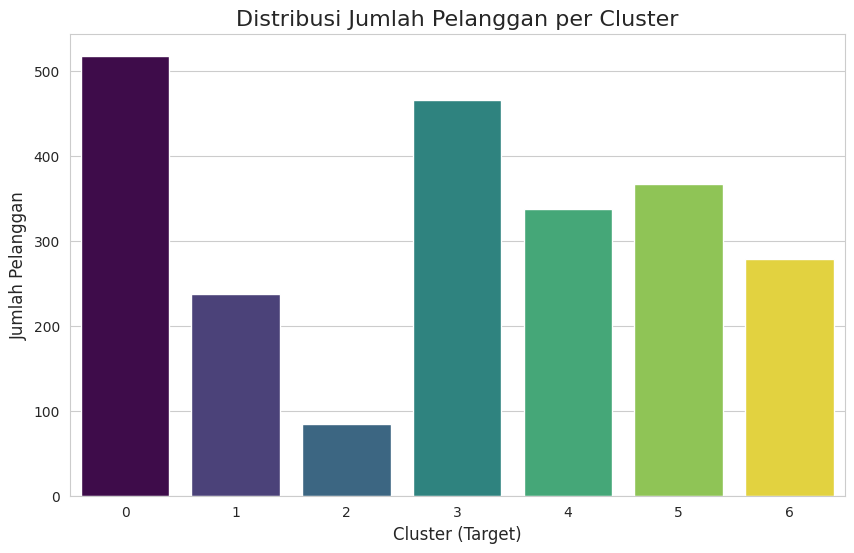

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=df, palette='viridis', hue='Target', legend=False)
plt.title('Distribusi Jumlah Pelanggan per Cluster', fontsize=16)
plt.xlabel('Cluster (Target)', fontsize=12)
plt.ylabel('Jumlah Pelanggan', fontsize=12)
plt.show()

## **4. Prapemrosesan dan Pembagian Data**

### **4.1. Pemisahan Fitur (X) dan Target (y)**

Memisahkan DataFrame menjadi dua bagian: `X` yang berisi semua fitur prediktor, dan `y` yang berisi kolom `Target` (label cluster).

In [33]:
X = df.drop('Target', axis=1)
y = df['Target']
print("[INFO] Fitur (X) dan Target (y) telah dipisahkan.")

[INFO] Fitur (X) dan Target (y) telah dipisahkan.


### **4.2. Encoding Fitur Kategorikal**

Meskipun data sudah diproses di tahap clustering, data hasil `inverse_transform` mengembalikan fitur kategorikal ke bentuk aslinya (string). Oleh karena itu, kita perlu melakukan encoding sekali lagi.

In [34]:
categorical_cols = X.select_dtypes(include=['object']).columns

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

print("[PROSES] Encoding fitur kategorikal selesai.")
display(X.head())

[PROSES] Encoding fitur kategorikal selesai.


,TransactionAmount,TransactionType,Location,Channel,CustomerOccupation,TransactionDuration,LoginAttempts,AgeBin,AccountBalanceBin
0,14.09,1,36,0,0,81.0,1.0,2.0,0.0
1,376.24,1,15,0,0,141.0,1.0,2.0,2.0
2,126.29,1,23,2,3,56.0,1.0,1.0,1.0
3,184.50,1,33,2,3,25.0,1.0,1.0,2.0
4,92.15,1,28,0,3,172.0,1.0,1.0,1.0


### **4.3. Pembagian dan Penskalaan Data**

Membagi data menjadi set pelatihan (80%) dan pengujian (20%). Penskalaan `StandardScaler` diterapkan setelah pembagian untuk mencegah *data leakage*.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Ukuran Data Latih (X_train): {X_train.shape}")
print(f"Ukuran Data Uji (X_test): {X_test.shape}")

Ukuran Data Latih (X_train): (1832, 9)
Ukuran Data Uji (X_test): (459, 9)


In [36]:
numerical_cols = X.columns

scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("[PROSES] Standard Scaling selesai.")
display(X_train.head())

[PROSES] Standard Scaling selesai.


,TransactionAmount,TransactionType,Location,Channel,CustomerOccupation,TransactionDuration,LoginAttempts,AgeBin,AccountBalanceBin
879,-0.693905,-1.785805,-0.021973,1.200286,0.419464,-0.191529,-0.204693,1.032331,-0.972305
1042,0.195050,0.481412,-1.551634,1.200286,0.419464,0.416706,-0.204693,1.032331,0.297305
1538,-0.720739,0.481412,1.024637,1.200286,1.300724,-1.040228,-0.204693,-0.199741,0.297305
1940,0.746128,0.481412,0.541587,1.200286,-0.461796,-0.686603,-0.204693,-1.431812,0.297305
1844,2.924528,0.481412,1.588197,1.200286,-0.461796,0.671315,-0.204693,-1.431812,-0.972305


## **5. Pelatihan dan Evaluasi Model Baseline**

Melatih dua model klasifikasi (Decision Tree dan Random Forest) sebagai perbandingan awal untuk melihat model mana yang memberikan performa lebih baik pada dataset ini.

### **5.1. Pelatihan Model**

In [37]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
print("[SELESAI] Model Decision Tree berhasil dilatih.")

[SELESAI] Model Decision Tree berhasil dilatih.


In [38]:
joblib.dump(dt_model, 'decision_tree_model.h5')
print("Model Decision Tree berhasil disimpan sebagai 'decision_tree_model.h5'")

Model Decision Tree berhasil disimpan sebagai 'decision_tree_model.h5'


In [39]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("[SELESAI] Model Random Forest berhasil dilatih.")

[SELESAI] Model Random Forest berhasil dilatih.


In [40]:
joblib.dump(rf_model, 'explore_RandomForest_classification.h5')
print("Model Random Forest berhasil disimpan sebagai 'explore_RandomForest_classification.h5'")

Model Random Forest berhasil disimpan sebagai 'explore_RandomForest_classification.h5'


### **5.2. Evaluasi Performa Model Baseline**

In [41]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("--- Laporan Klasifikasi Decision Tree ---")
print(classification_report(y_test, y_pred_dt))

print("\n--- Laporan Klasifikasi Random Forest ---")
print(classification_report(y_test, y_pred_rf))

--- Laporan Klasifikasi Decision Tree ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       104
           1       0.96      0.92      0.94        48
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        93
           4       0.98      0.93      0.95        68
           5       0.96      0.96      0.96        73
           6       0.89      0.98      0.93        56

    accuracy                           0.97       459
   macro avg       0.97      0.97      0.97       459
weighted avg       0.97      0.97      0.97       459


--- Laporan Klasifikasi Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       104
           1       1.00      0.90      0.95        48
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        93
           4       0.98      0.94      0.96    

## **6. Optimisasi Model dengan Hyperparameter Tuning**

Berdasarkan evaluasi, Random Forest menunjukkan performa yang lebih baik. Oleh karena itu, kita akan melakukan optimisasi pada model ini menggunakan `GridSearchCV` untuk menemukan kombinasi hyperparameter terbaik.

In [42]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

print("[PROSES] Memulai proses hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("[SELESAI] Proses tuning selesai.")

[PROSES] Memulai proses hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[SELESAI] Proses tuning selesai.


## **7. Evaluasi Akhir dan Penyimpanan Model Final**

Mengevaluasi performa model Random Forest dengan hyperparameter terbaik pada data uji dan menyimpannya sebagai model produksi final.

In [43]:
best_rf_model = grid_search.best_estimator_

y_pred_tuned = best_rf_model.predict(X_test)
print("--- Laporan Klasifikasi Random Forest (Setelah Tuning) ---")
print(classification_report(y_test, y_pred_tuned))

--- Laporan Klasifikasi Random Forest (Setelah Tuning) ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       104
           1       1.00      0.92      0.96        48
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        93
           4       0.98      0.94      0.96        68
           5       0.94      0.99      0.96        73
           6       0.90      0.96      0.93        56

    accuracy                           0.97       459
   macro avg       0.97      0.97      0.97       459
weighted avg       0.98      0.97      0.97       459



In [44]:
joblib.dump(best_rf_model, 'tuning_classification.h5')
print("[SELESAI] Model hasil tuning berhasil disimpan sebagai 'tuning_classification.h5'")

[SELESAI] Model hasil tuning berhasil disimpan sebagai 'tuning_classification.h5'


### **Proyek Klasifikasi Selesai**

Alur kerja klasifikasi telah selesai. Model prediktif yang optimal kini siap untuk diimplementasikan untuk mengklasifikasikan nasabah baru ke dalam segmen yang ada.